# Simulating wiring rules in silico
### Demonstration of how to simulate connectomes using the three rule variants used in the paper.

In [2]:
from consbi.simulators import DistanceRuleSimulator, RuleSimulator, poisson_glm, peters_rule_subcellular
from consbi.simulators import default_rule
from torch.distributions import MultivariateNormal

from sbi.inference import prepare_for_sbi, simulate_for_sbi
from sbi.utils import BoxUniform

import torch
import matplotlib.pyplot as plt
plt.style.use('../paper/.matplotlibrc')
%matplotlib inline

In [3]:
# The prior will be Gaussian for most rules.
prior = MultivariateNormal(torch.ones(3), torch.eye(3))

## Poisson GLM

The problem is reduced to just 10 neuron-pair-subvolume combinations withtout summary statistics, i.e., the simulator returns the raw synapse counts sampled from a Poisson distribution. Thus, it is fast and tractable. 

In [3]:
theta = prior.sample((10000,))
x = poisson_glm(theta)

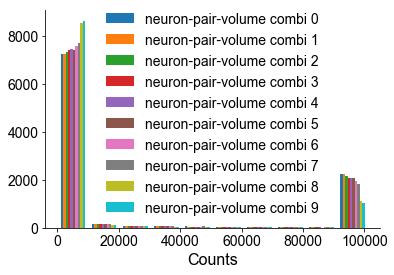

In [4]:
plt.hist(x.numpy())
plt.xlabel("Counts")
plt.legend([f"neuron-pair-volume combi {ii}" for ii in range(10)]);

## Generalized DSO-rule

The simulator is applied to the full barrel cortex column with more then 14 million neuron-pair-subvolume combinations, and summary statistics are calculated. Thus, the simulator returns 7 numbers and is intractable.

In [5]:
path_to_model = "../data/structural_model"
# set number of neuron pairs sampled from the connectome to mimick experimental settings, e.g., 50
num_subsampling_pairs = 50
simulator = RuleSimulator(path_to_model, default_rule, verbose=True, num_subsampling_pairs=num_subsampling_pairs)

loading features ...
Time elapsed: 124.77493691444397


/Users/janbolts/qode/sbi-for-connectomics/consbi/simulators/rule_simulator.py:650: RuntimeWarning: invalid value encountered in log
  log_features = np.log(features)


constraint 0, num rows (with overlap) 2168393
constraint 1, num rows (with overlap) 687074
constraint 2, num rows (with overlap) 308345
constraint 3, num rows (with overlap) 674175
constraint 4, num rows (with overlap) 559727
constraint 5, num rows (with overlap) 587659
constraint 6, num rows (with overlap) 1096435


In [6]:
num_simulations = 100
# wrap the simulator to handle batches of parameters
batch_simulator, prior = prepare_for_sbi(simulator, prior)

theta, x = simulate_for_sbi(batch_simulator, prior, num_simulations=num_simulations, num_workers=1)


Running 100 simulations.:   0%|          | 0/100 [00:00<?, ?it/s]

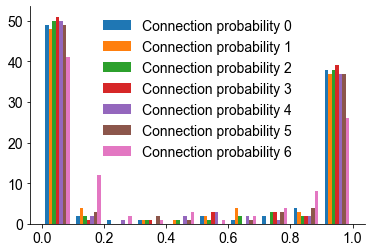

In [8]:
plt.hist(x.numpy())
plt.legend([f"Connection probability {ii}" for ii in range(7)]);

## Distance based rules

The last example are wiring rules that form connections solely based on how close the neurons are to each other. 

There two variants:
 - one that acts at the neuron-level, simulating connections for every neuron pair
 - and one that acts at the subcellular level, simulating connections (synapses) for each neuron-pair in every subvolume.

Both variants can be applied at different levels of resolution of the structural model, i.e., the side length of the subvolume (cube size).

### Neuron level
The neuron level rule has its own class for simulating corresponding connectomes: `DistanceRuleSimulator`. 
There are different sets of structural features: set 6 for the neuron level, and set 7 for the synapse level.

Similarly, there are different rule functions and features that need to be passed to the simulator: 
    - number of `common_cubes` as features and the `cutoff_rule` as rule for the neuron level
    - for the synapse level rule, there is a separate function `rule_subcellular`

### Synapse level
However, the synapse level rule, because it has ixjxk entries to simulate, can be very slow in this simple implementation without prelocation. Thus, for simulating the synapse level rule we return to the original simulator `RuleSimulator`.

### Neuron level

using feature set-6


Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

Text(0, 0.5, 'count')

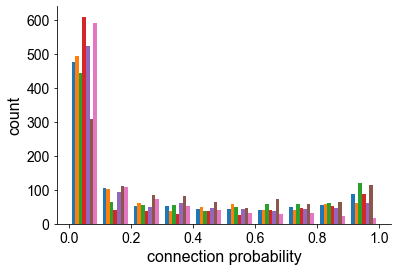

In [3]:
path_to_model = "../data/structural_model"
path_to_features = "../data/cube_model"
# set number of neuron pairs sampled from the connectome to mimick experimental settings, e.g., 50
num_subsampling_pairs = 50
cube_size = 50
num_simulations = 1000

# Select feature sets:
#     "set-7"  # holds subcellular level features: 1 if two neurons meet in a voxel, 0 else., ixjxk entries
#     "set-6"  # Set 6 holds the common cubes for different cube sizes. ixj entries
#     "set-5"  # Set 5 holds common cubes, min distance and axon-dendrite product for cube size 50mu-m

prior = BoxUniform(torch.zeros(1), torch.ones(1) * 100)
model = DistanceRuleSimulator(path_to_model, path_to_features,
                            feature_set_name="set-6", 
                            num_subsampling_pairs=num_subsampling_pairs, cube_size=cube_size)

def batch_simulator(theta):
    return model.rule(theta, 
        feature=model.common_cubes, #  Corresponds to feature set 6.
        connection_fun=model.cutoff_rule  # cutoff rule forms a connection when feature crosses a threshold.
    )


theta, x = simulate_for_sbi(batch_simulator, prior, num_simulations=num_simulations, num_workers=1)

plt.hist(x.numpy())
plt.xlabel("connection probability")
plt.ylabel("count")

### Synapse level 

In [4]:
path_to_model = "../data/subcellular_features"
# set number of neuron pairs sampled from the connectome to mimick experimental settings, e.g., 50
num_subsampling_pairs = 50
cube_size = 1
num_simulations = 1000

prior = torch.distributions.Beta(
    concentration1=torch.ones(1) * 0.5, concentration0=torch.ones(1) * 0.5
)

simulator = RuleSimulator(
    path_to_model,
    peters_rule_subcellular,
    verbose=False,
    num_subsampling_pairs=num_subsampling_pairs,
    experiment_name="peters-subcellular",
)
batch_simulator, prior = prepare_for_sbi(simulator, prior)

Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

Text(0, 0.5, 'count')

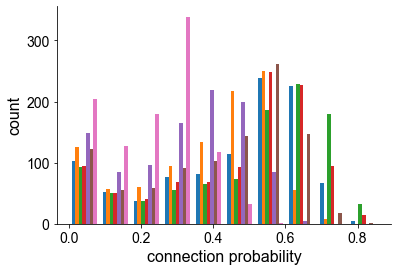

In [5]:
theta, x = simulate_for_sbi(batch_simulator, prior, num_simulations=num_simulations, num_workers=1)
plt.hist(x.numpy())
plt.xlabel("connection probability")
plt.ylabel("count")